In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from numpy import *
from scipy.linalg import kron

In [10]:
# Define parameters
tspan = np.linspace(0, 4, 9)
tshoot = [0, 4]
D1 = 0.1
D2 = 0.1
m = 1
beta = 1
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
U = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
V = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))

In [13]:
# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

# Define the ODE system
def spc_rhs(t, UVt2, nx, ny, N, K, beta,D1,D2):
    Utc = UVt2[0: N]
    Vtc = UVt2[N: 2*N]
    Ut = Utc.reshape((nx, ny)) 
    Vt = Vtc.reshape((nx, ny))
    Uo = ifft2(Ut)
    Vo = ifft2(Vt)
    rhsup = (fft2(Uo - Uo**3 - Vo**2 * Uo + beta * Uo**2 * Vo + beta * Vo**3) - D1 * K * Ut).reshape(N)
    rhsdown = (fft2(-beta * Uo**3 - beta * Vo**2 * Uo + Vo - Uo**2 * Vo - Vo**3) - D2 * K * Vt).reshape(N)
    return np.hstack([rhsup,rhsdown])

[[ 24.94003847+0.00000000e+00j  12.73268299-1.48859140e-15j
   -1.38095598-2.64985836e-15j ... -64.02389647-1.29024808e-14j
  -67.76356741-2.02698636e-14j -61.18058974-2.99457619e-14j]
 [-18.55666362-5.81663109e+01j -42.51586944-4.69129224e+01j
  -60.80795253-2.57480390e+01j ... -26.39439597+1.13082890e+02j
    6.86544434+1.23000456e+02j  41.4436393 +1.10055312e+02j]
 [-16.04755868+3.28279829e+01j -22.03971648-4.57977740e+01j
  -23.23089505-1.04141716e+02j ... -25.03391682-9.26527314e+01j
  -29.2936105 -4.09594873e+01j -31.3712619 +1.56986891e+01j]
 ...
 [ 24.73021466-5.66774723e+02j  34.94179045-3.31372917e+02j
   38.82924248-4.97842318e+01j ...   4.99619196+6.02396295e+02j
   -9.93322885+4.90736906e+02j -25.6299042 +2.81792021e+02j]
 [ 25.33720124-3.61633792e+02j  43.00958768-4.53711746e+02j
   51.93221654-4.47841562e+02j ... -30.76392977+2.66442187e+02j
  -58.45411318+4.29165358e+02j -74.0191717 +5.05315322e+02j]
 [ -6.4753501 +3.96245454e+01j  15.86720969-5.83358549e+01j
   37.7389

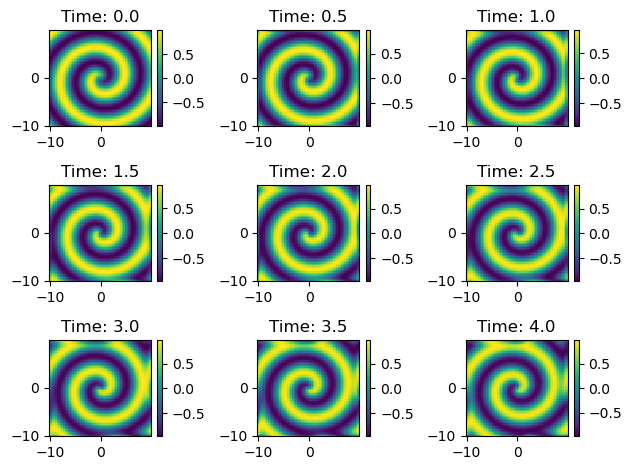

In [14]:
# Solve the ODE and plot the results
wt0= np.hstack([fft2(U).reshape(N), fft2(V).reshape(N)])
wtsol = solve_ivp(spc_rhs, tshoot, wt0, t_eval = tspan, args=(nx, ny, N, K, beta, D1, D2), method = 'RK45')
A1 = wtsol.y
print(A1)

for j, t in enumerate(tspan):
    w = np.real(ifft2(wtsol.y[N:,j].reshape((nx, ny))))
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w)
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [48]:
def cheb(N):
    if N==0: 
        D = 0.; x = 1.
    else:
        n = arange(0,N+1)
        x = cos(pi*n/N).reshape(N+1,1) 
        c = (hstack(( [2.], ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
        X = tile(x,(1,N+1))
        dX = X - X.T
        D = dot(c,1./c.T)/(dX+eye(N+1))
        D -= diag(sum(D.T,axis=0))
    return D, x.reshape(N+1)

In [49]:
N = 30
D, xo = cheb(N)
D[N, :] = 0
D[0, :] = 0
D = 0.1 * D
Ddouble = np.dot(D, D)
nx, ny = N+1, N+1
Nxy = nx * ny

x = 10 * xo
y = x
X,Y = np.meshgrid(x,y)
I = np.eye(len(Ddouble))
L = kron(I, Ddouble) + kron(Ddouble, I)

U = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
V = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))

print(Nxy)

961


In [50]:
def spc_rhs2(t, UVt2, Nxy, L, beta, D1, D2):
    Utc = UVt2[0: Nxy]
    Vtc = UVt2[Nxy: 2*Nxy]
    rhsup = (Utc - Utc**3 - Vtc**2 * Utc + beta * Utc**2 * Vtc + beta * Vtc**3 + D1 * np.dot(L, Utc)).reshape(Nxy)
    rhsdown = (-beta * Utc**3 - beta * Vtc**2 * Utc + Vtc - Utc**2 * Vtc - Vtc**3 + D2 * np.dot(L, Vtc)).reshape(Nxy)
    return np.hstack([rhsup, rhsdown])

[[ 0.70358468  0.27678435 -0.21775865 ... -0.79689015 -0.40972859
   0.07776933]
 [ 0.73241275  0.47188952  0.07344742 ... -0.96577657 -0.78500366
  -0.4261521 ]
 [ 0.81058026  0.37605887 -0.11123233 ... -0.84008598 -0.49565779
  -0.03085913]
 ...
 [ 0.58562756  0.91352592  0.97914313 ... -0.50294695 -0.84298442
  -0.97634716]
 [ 0.6808609   0.87018536  0.97997159 ... -0.16453512 -0.5878894
  -0.88455009]
 [ 0.71061143  0.96093661  0.97601586 ... -0.60413504 -0.91222169
  -0.99697897]]


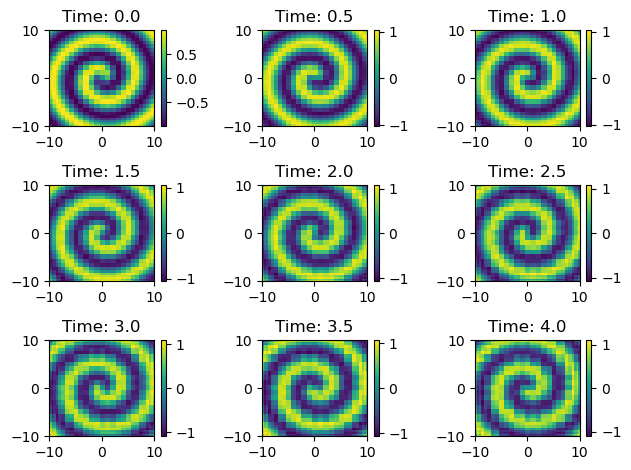

In [51]:
wt0= np.hstack([U.reshape(Nxy), V.reshape(Nxy)])
wtsol = solve_ivp(spc_rhs2, tshoot, wt0, t_eval = tspan, args=(Nxy, L, beta, D1, D2), method = 'RK45')
A2 = wtsol.y

print(A2)
for j, t in enumerate(tspan):
    w = wtsol.y[:Nxy,j].reshape((nx, ny))
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w)
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()